In [1]:
import torch
import torch.utils.data as Data
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

0.3.1.post2


# Generate time series data

In [2]:
t = torch.linspace(0, 2*np.pi, 500).view(500, 1)
print(t.shape)

torch.Size([500, 1])


In [3]:
ts1 = 2*np.sin(t) + 3*np.cos(t)+0.1*torch.rand(t.size())
print(ts1.shape)

torch.Size([500, 1])


In [4]:
ts2 =  5*np.sin(t) + 2*np.cos(t)+0.2*torch.rand(t.size())
print(ts2.shape)

torch.Size([500, 1])


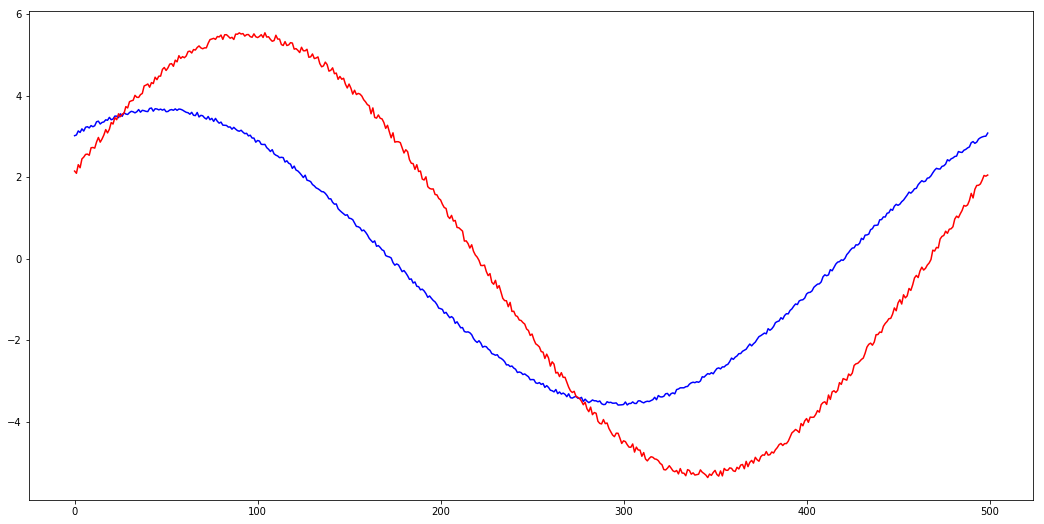

In [5]:
plt.figure(figsize=(18,9)) # set the figure size to 18 x 9 inches
plt.plot(ts1.numpy(), c='blue')
plt.plot(ts2.numpy(), c='red')
plt.show()

# Generate training x, y windows 

In [6]:
tensor = ts1[0:10]
print(tensor.shape)

torch.Size([10, 1])


In [7]:
tensor = ts1[0:10].view(1, 10, 1)
print(tensor.shape)

torch.Size([1, 10, 1])


In [8]:
train_x = ts1[0:10].view(1, 10, 1)
train_y = ts2[0:10].view(1, 10, 1)
begin = 1
time_step = 10
end = begin + time_step
while (end < 500):
    tmpx = ts1[begin: end]
    tmpy = ts2[begin: end]
    tmpx = tmpx.view(1, 10, 1)
    tmpy = tmpy.view(1, 10, 1)
    train_x = torch.cat((train_x, tmpx), 0)
    train_y = torch.cat((train_y, tmpy), 0)
    begin = begin + 1
    end = begin + time_step

In [9]:
print(train_x.shape, train_y.shape) # we have built 500 windows

torch.Size([490, 10, 1]) torch.Size([490, 10, 1])


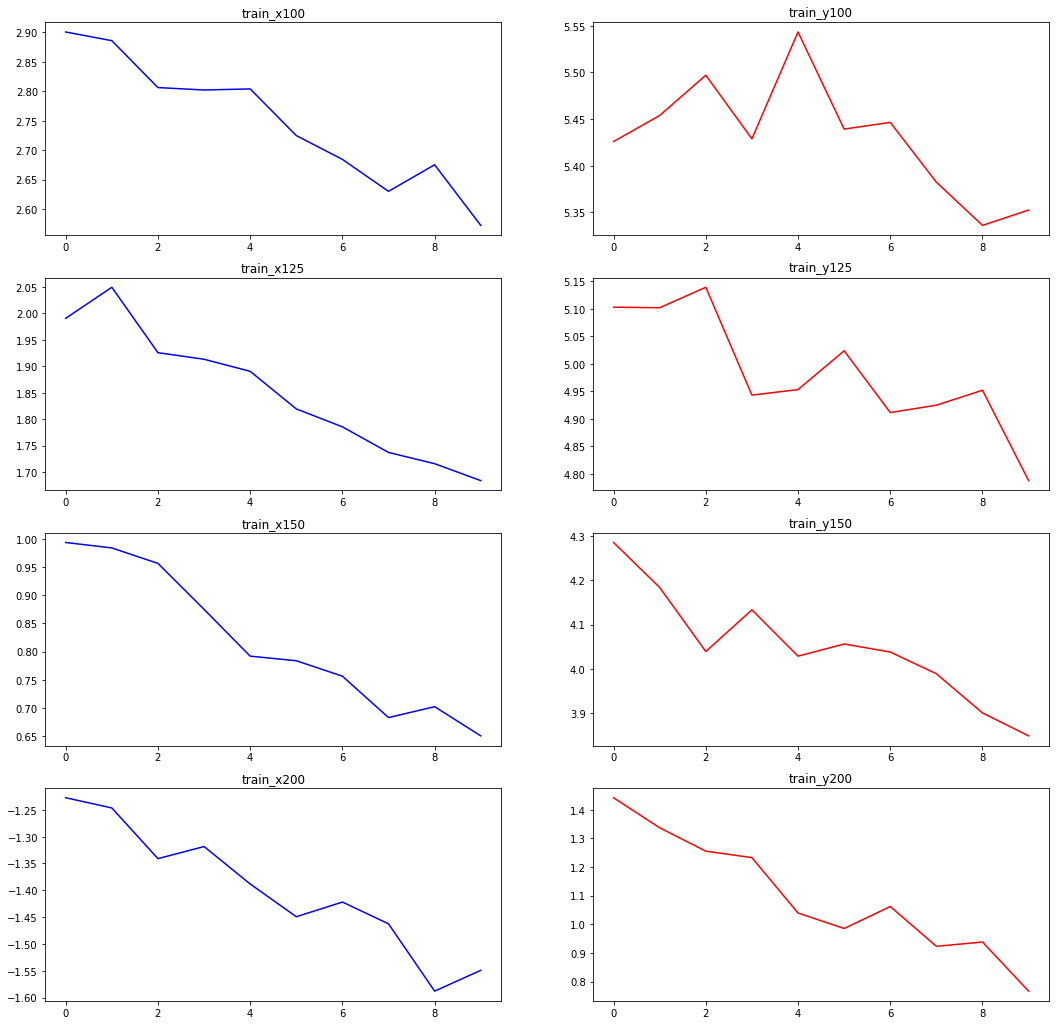

In [10]:
fig = plt.figure(figsize=(18, 18))
sub = 1
for i in [100, 125, 150, 200]:
    a=fig.add_subplot(4,2, sub) # we have a 2 rows * 4 columns subplots
    plt.plot(train_x[i].numpy(), c='blue')
    title = 'train_x' + str(i)
    plt.title(title)

    sub = sub +1
    a=fig.add_subplot(4,2, sub)
    plt.plot(train_y[i].numpy(), c='red')
    title = 'train_y' + str(i)
    plt.title(title)
    sub = sub + 1
plt.show()

# Build data loader

In [11]:
torch_dataset = Data.TensorDataset(data_tensor=train_x, target_tensor=train_y)

In [12]:
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=245,             # mini batch size 490/2=245
    shuffle=True,               # random shuffle for training
    num_workers=2,              # subprocesses for loading data
)

# Define NN

In [13]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=1,
            hidden_size=32,     # rnn hidden unit
            num_layers=1,       # number of rnn layer
            batch_first=True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(32, 1)

    def forward(self, x, h_state):
        # x (batch, time_step, input_size)
        # h_state (n_layers, batch, hidden_size)
        # r_out (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)

        outs = []    # save all predictions
        for time_step in range(r_out.size(1)):    # calculate output for each time step
            outs.append(self.out(r_out[:, time_step, :]))
        return torch.stack(outs, dim=1), h_state

In [14]:
rnn = RNN()

In [15]:
rnn

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

# optimizer and loss function

In [16]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.2)   # optimize all cnn parameters
loss_func = nn.MSELoss()

# Run one traing epoc step by step to understand details

In [17]:
for step, (batch_x, batch_y) in enumerate(loader): 
    break

In [18]:
print(step, batch_x.shape, batch_y.shape)

0 torch.Size([245, 10, 1]) torch.Size([245, 10, 1])


In [19]:
b_x = Variable(batch_x)           
b_y = Variable(batch_y)       
print(b_x.shape, b_y.shape)

torch.Size([245, 10, 1]) torch.Size([245, 10, 1])


In [20]:
h_state = None      # for initial hidden state

In [21]:
prediction, h_state = rnn(b_x, h_state)

In [22]:
prediction.shape

torch.Size([245, 10, 1])

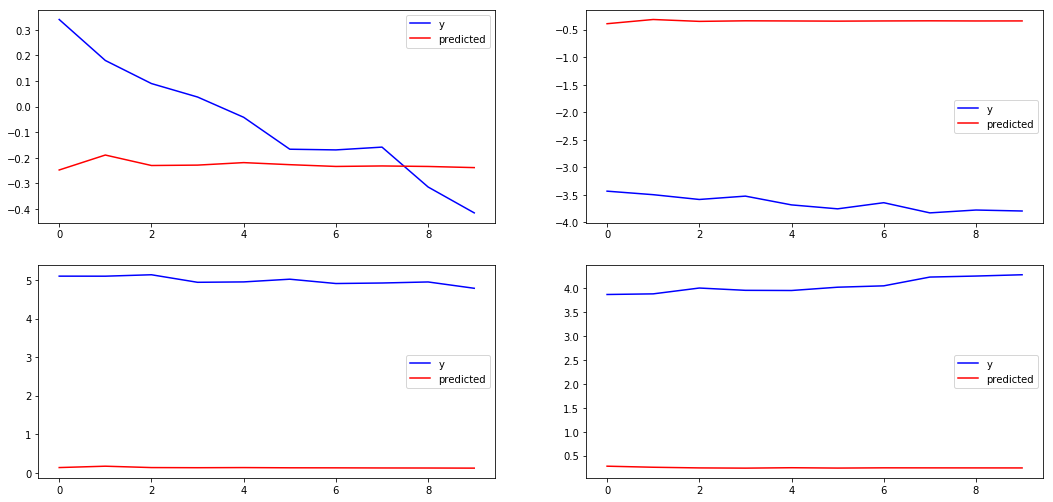

In [23]:
fig = plt.figure(figsize=(18, 18))
sub = 1
for i in [0, 50, 100, 150]:
    a=fig.add_subplot(4, 2, sub) # we have a 2 rows * 4 columns subplots
    plt.plot(b_y[i].data.numpy(), c='blue', label="y")
    plt.plot(prediction[i].data.numpy(), c='red', label = "predicted")
    plt.legend()
    sub = sub + 1
plt.show()

In [24]:
h_state

Variable containing:
( 0 ,.,.) = 
  4.2269e-01  5.6525e-01 -5.0748e-01  ...   1.6384e-01  5.0344e-01  2.5954e-01
  4.9393e-01  6.9717e-01 -5.5109e-01  ...   1.9973e-01  7.0520e-01  3.1765e-01
  3.9947e-01  5.2154e-01 -4.9189e-01  ...   1.5119e-01  4.3441e-01  2.4059e-01
                 ...                   ⋱                   ...                
  4.7110e-01  6.6499e-01 -5.4023e-01  ...   1.8466e-01  6.5377e-01  3.0191e-01
  4.3239e-02 -5.1972e-01 -1.2467e-01  ...  -3.0385e-02 -7.9189e-01 -1.3648e-01
  2.8278e-02 -5.4308e-01 -1.1111e-01  ...  -4.1695e-02 -8.0640e-01 -1.4744e-01
[torch.FloatTensor of size 1x245x32]

In [25]:
loss = loss_func(prediction, b_y) 

In [26]:
loss

Variable containing:
 13.6802
[torch.FloatTensor of size 1]

In [27]:
loss.data.numpy()[0]

13.680196

# Training loop

In [28]:
h_state = None      # for initial hidden state

In [29]:
losslst = []
for epoch in range(30):  #run only one epoc
    for step, (batch_x, batch_y) in enumerate(loader):     
        b_x = Variable(batch_x)           
        b_y = Variable(batch_y)   

        prediction, h_state = rnn(b_x, h_state)   # rnn output
        # !! next step is important !!
        h_state = Variable(h_state.data)        # repack the hidden state, break the connection from last iteration

        loss = loss_func(prediction, b_y)         # cross entropy loss
        losslst.append(loss.data.numpy()[0])

        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                         # backpropagation, compute gradients
        optimizer.step()                        # apply gradients

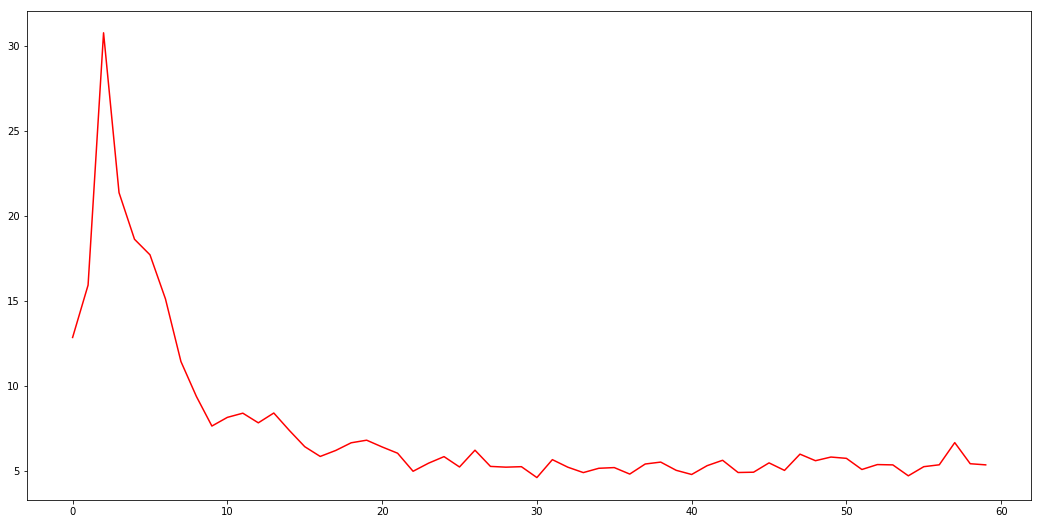

In [ ]:
plt.figure(figsize=(18,9)) # set the figure size to 18 x 9 inches
plt.plot(losslst, color = 'red')
plt.show()

In [ ]:
fig = plt.figure(figsize=(18, 18))
sub = 1
for i in [0, 50, 100, 150]:
    a=fig.add_subplot(4, 2, sub) # we have a 2 rows * 4 columns subplots
    plt.plot(b_y[i].data.numpy(), c='blue', label="y")
    plt.plot(prediction[i].data.numpy(), c='red', label = "predicted")
    plt.legend()
    sub = sub + 1
plt.show()